In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import io
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
from matplotlib import rcParams
from numpy.fft import fft, ifft

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, LSTM
from keras import optimizers
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

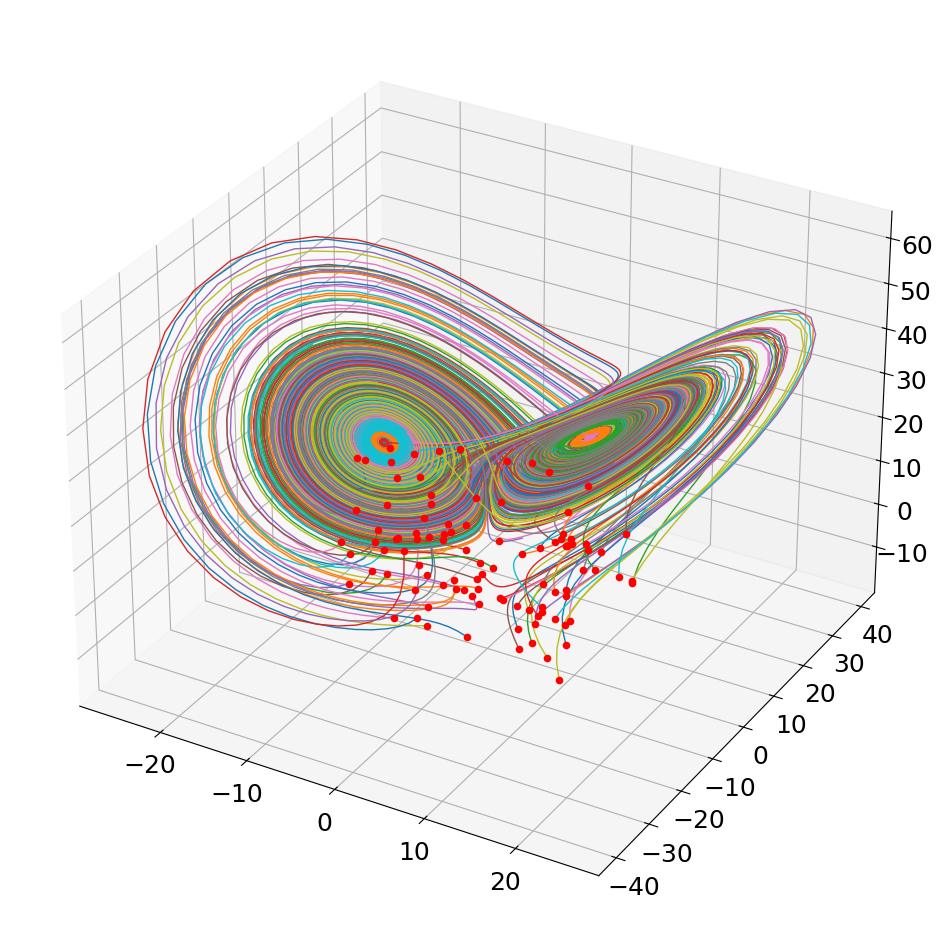

In [2]:

dt = 0.01; T = 8; t = np.arange(0,T+dt,dt)
beta = 8/3; sigma = 10; rho = 28

nn_input = np.zeros((100*(len(t)-1), 3))
nn_output = np.zeros_like(nn_input)

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})

def lorenz_deriv(x_y_z,t0,sigma=sigma,beta=beta,rho=rho):
    x, y, z = x_y_z
    return [sigma * (y-x), x * (rho - z) -y, x * y - beta * z]

np.random.seed(123)

x0 = -15 + 30 * np.random.random((100,3))
x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0])

for j in range(100):
    nn_input[j * (len(t) - 1) : (j + 1) * (len(t) - 1), :] = x_t[j,: -1,:]
    nn_output[j * (len(t) - 1) : (j + 1) * (len(t) - 1), :] = x_t[j,1:,:]
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')

In [15]:
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

net = Sequential([
    Dense(10, activation='sigmoid', input_shape=(3,)),  # Corrected input_shape parameter
    Dense(10, activation='relu'),
    Dense(3, activation='linear')
])

sgd_optimizer = optimizers.SGD(momentum=0.9)
net.compile(loss='mse', optimizer='adam')

history = net.fit(nn_input, nn_output, epochs=20)  # Lower epochs if it's still crashing


Epoch 1/20
2500/2500 [==============================] - 7s 3ms/step - loss: 42.5806
Epoch 2/20
2500/2500 [==============================] - 7s 3ms/step - loss: 1.7435
Epoch 3/20
2500/2500 [==============================] - 7s 3ms/step - loss: 0.5807
Epoch 4/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.2303
Epoch 5/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1122
Epoch 6/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0684
Epoch 7/20
2500/2500 [==============================] - 7s 3ms/step - loss: 0.0496
Epoch 8/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0404
Epoch 9/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0348
Epoch 10/20
2500/2500 [==============================] - 7s 3ms/step - loss: 0.0300
Epoch 11/20
2500/2500 [==============================] - 7s 3ms/step - loss: 0.0271
Epoch 12/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0247


In [16]:
num_traj = 2
ynn = np.zeros((num_traj, len(t), 3))
ynn[:, 0, :] = -15 + 30 * np.random.random((num_traj, 3))
for jj, tval in enumerate(t[:-1]):
    ynn[:, jj + 1, :] = net.predict(ynn[:, jj, :])

1/1 [==============================] - 0s 57ms/step


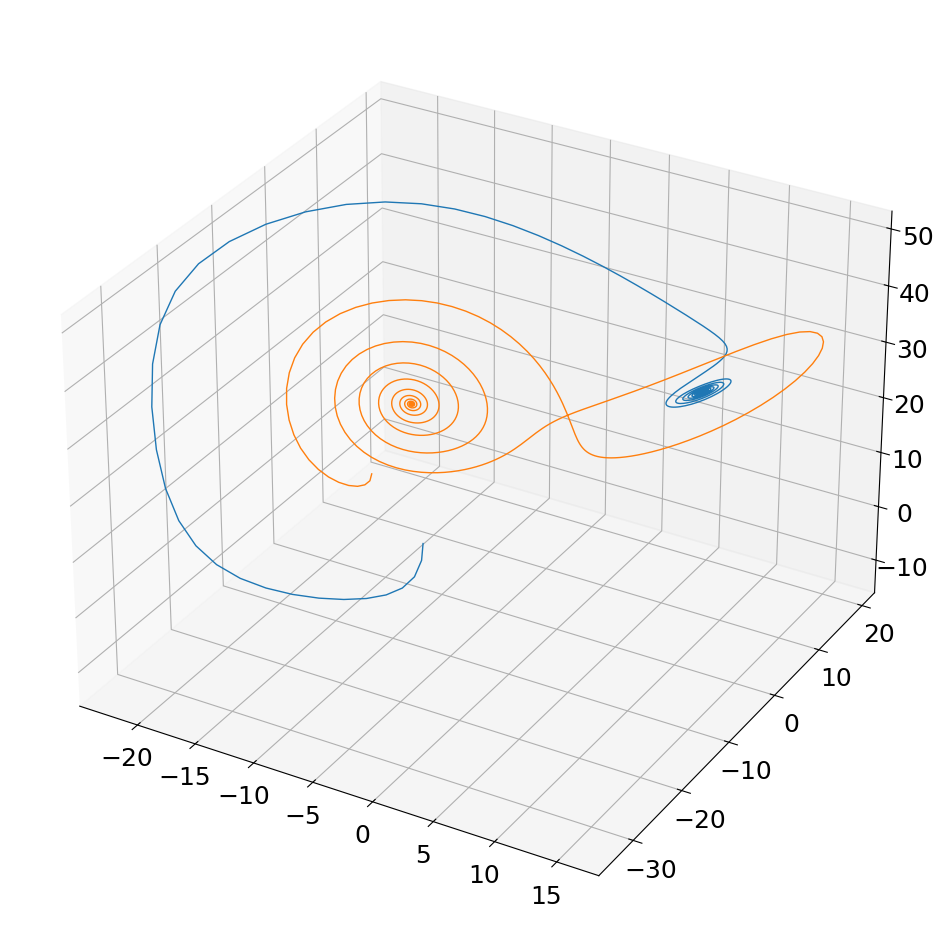

In [25]:

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})

for j in range(len(ynn)):
    x, y, z = ynn[j, :, :].T  # Transpose to separate x, y, z
    ax.plot(x, y, z, linewidth=1)


In [21]:
plt.show()

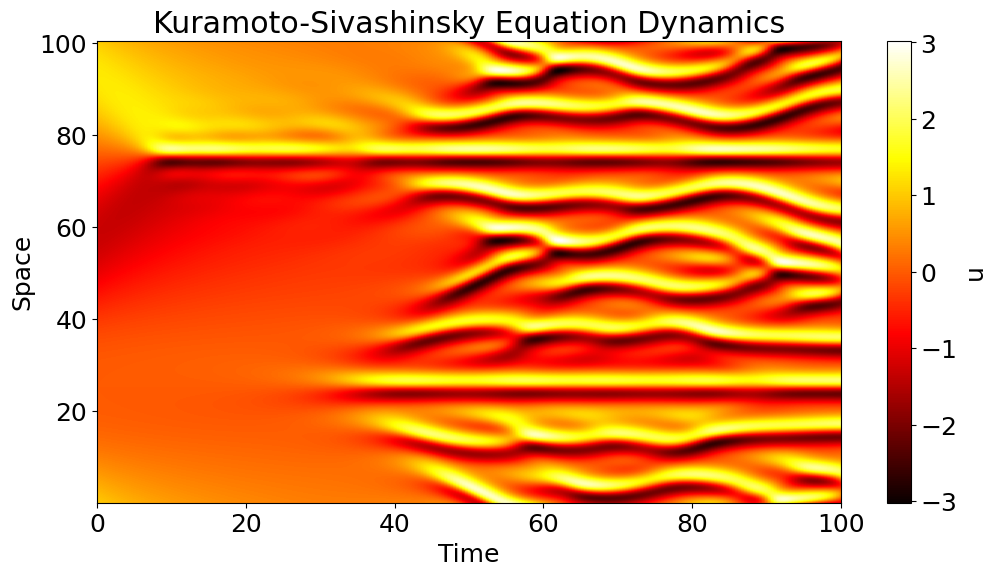

In [112]:
# Kuramoto-Sivashinsky equation (from Trefethen)
# u_t = -u*u_x - u_xx - u_xxxx, periodic BCs

# Kuramoto-Sivashinsky equation setup
N = 1024
x = 32 * np.pi * (np.arange(1, N + 1) / N).reshape(N, 1)
u = np.cos(x / 16) * (1 + np.sin(x / 16))
u = u.reshape(N)
v = fft(u)

# Parameters for the equation
h = 0.025
k = np.concatenate([np.arange(0, N/2), [0], np.arange(-N/2 + 1, 0)]) / 16
L = k**2 - k**4
E = np.exp(h*L)
E2 = np.exp(h*L/2)
M = 16
r = np.exp(1j * np.pi * (np.arange(1, M + 1) - 0.5) / M)
LR = h * np.outer(L, np.ones(M)) + np.outer(np.ones(N), r)
Q = h * np.real(np.mean((np.exp(LR/2) - 1) / LR, axis=1))
f1 = h * np.real(np.mean((-4 - LR + np.exp(LR) * (4 - 3*LR + LR**2)) / LR**3, axis=1))
f2 = h * np.real(np.mean((2 + LR + np.exp(LR) * (-2 + LR)) / LR**3, axis=1))
f3 = h * np.real(np.mean((-4 - 3*LR - LR**2 + np.exp(LR) * (4 - LR)) / LR**3, axis=1))

# Time-stepping loop
tmax = 100
nmax = round(tmax/h)
nplt = int((tmax/250)/h)
g = -0.5j * k
uu = u[:, np.newaxis]
tt = 0

for n in range(1, nmax + 1):
    t = n * h
    Nv = g * fft(np.real(ifft(v))**2)
    a = E2 * v + Q * Nv
    Na = g * fft(np.real(ifft(a))**2)
    b = E2 * v + Q * Na
    Nb = g * fft(np.real(ifft(b))**2)
    c = E2 * a + Q * (2 * Nb - Nv)
    Nc = g * fft(np.real(ifft(c))**2)
    v = E * v + Nv * f1 + 2 * (Na + Nb) * f2 + Nc * f3
    if n % nplt == 0:
        u = np.real(ifft(v))
        uu = np.hstack((uu, u.reshape(N, 1)))
        tt = np.append(tt, t)

plt.figure(figsize=(12, 6))
plt.imshow(uu, extent=[tt.min(), tt.max(), x.min(), x.max()], aspect='auto', cmap='hot')
plt.colorbar(label='u')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Kuramoto-Sivashinsky Equation Dynamics')
plt.show()




In [125]:
L = 250  # Length of the sequence expected by the model
feature_dim = 1024  # Number of features (spatial points)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(L, feature_dim)))
model.add(Dense(feature_dim))
model.compile(optimizer='adam', loss='mse')
nn_input = uu[:,0]
nn_output = uu[:,1:]
history = model.fit(nn_input, nn_output, epochs=100)  # Lower epochs if it's still crashing



predicted_states = []

for _ in range(100):
    next_state = model.predict(nn_input)
    predicted_states.append(next_state)
    # Update the sequence: remove the oldest state and append the new state
    current_sequence = np.vstack([current_sequence[1:], next_state])

predicted_states = np.array(predicted_states).reshape(-1, feature_dim)



Epoch 1/100


ValueError: in user code:

    File "c:\Users\mark.rainey\AppData\Local\anaconda3\envs\datascience\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\mark.rainey\AppData\Local\anaconda3\envs\datascience\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mark.rainey\AppData\Local\anaconda3\envs\datascience\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\mark.rainey\AppData\Local\anaconda3\envs\datascience\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\mark.rainey\AppData\Local\anaconda3\envs\datascience\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\mark.rainey\AppData\Local\anaconda3\envs\datascience\lib\site-packages\keras\engine\input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_50" "                 f"(type Sequential).
    
    Input 0 of layer "lstm_8" is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (32,)
    
    Call arguments received by layer "sequential_50" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(32,), dtype=float32)
      • training=True
      • mask=None


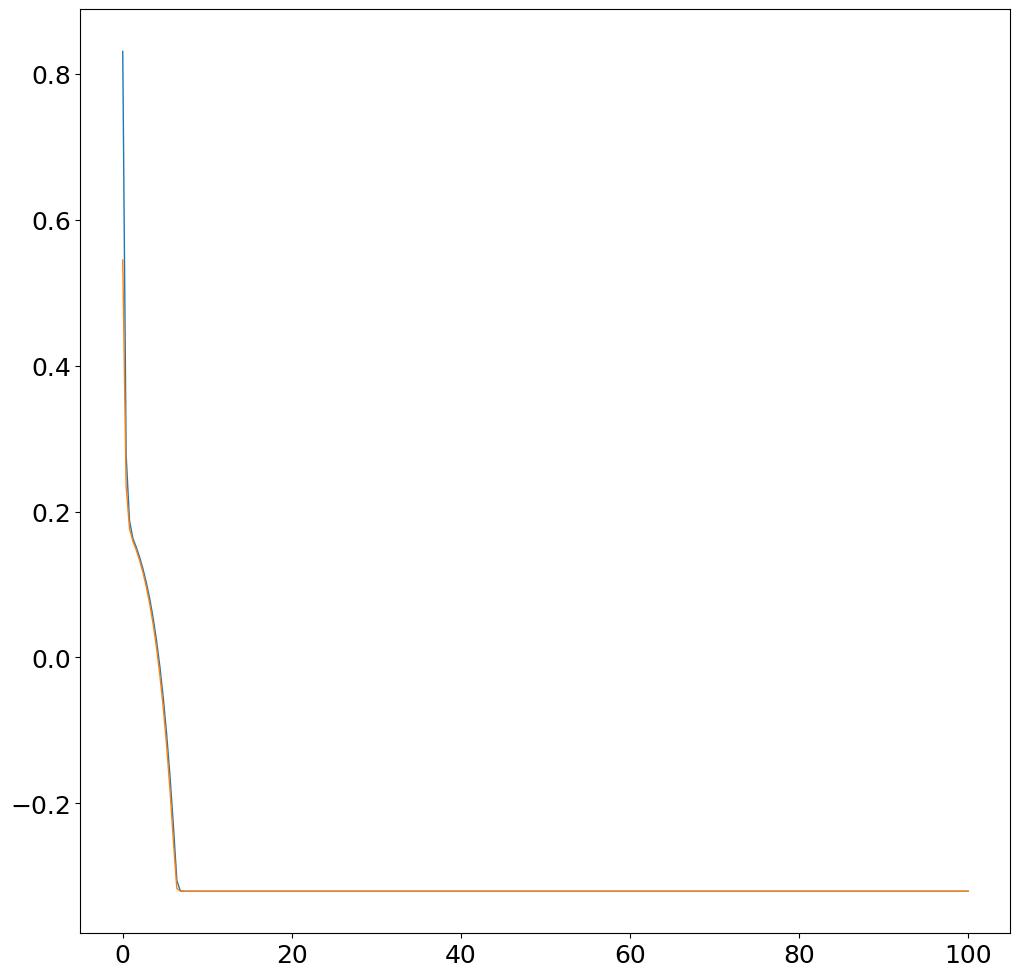

In [90]:

fig,ax = plt.subplots(1,1)
for j in range(len(propagated_states[:,j])):
    x = tt
    y = propagated_states[j,:]
    ax.plot(x, y, linewidth=1)
